## Lab 7: Eel Distribution Modeling with XGBoost

**Reference Paper:** [Elith et al. (2008)](https://ucsb.box.com/s/6k7636wsbogdg3orarxrlowke0ounbic)

In this lab, you will model the distribution of the eel species *Anguilla australis* using **boosted classification trees (BCTs)**, a machine learning technique that improves predictive performance by combining multiple decision trees. Elith et al. (2008) offered an early implementation of BRTs in an ecological setting to understand how environmental variables influence eel distribution.

You will work with **two datasets**:
1. **Training Data** – Used to build and evaluate your XGBoost model.
2. **Evaluation Data** – Used to assess model performance on unseen data.

To achieve the following objectives:
- Train and fine-tune an **XGBoost** model for classification of species presence/absence data.
- Compare your model’s performance to the approach used by Elith et al.


**Wherever applicable in this lab, use a random state of 808.**

### Step 0: Load libraries and data


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform, randint

# Download the datasets
model_data = pd.read_csv("Data/model.data.csv").drop(columns=['Site'])
eval_data = pd.read_csv("Data/eval.data.csv")

### Step 1:Initial Data Preprocessing
Let's get started by preparing our data. `Angaus` will be our target variable(`y`), and all other variables will be our features (`X`). Then encode the categorical feature using `LabelEncoder()`. The final step will be a bit different this time.  We don't need to split off testing data for the final model evaluation; a separate set (`eval_data`) will be used as in Elith et al.  We do, however, need to split our data in order to do the early stopping process. When splitting your data into training and validation, use a test size of 0.2 and a random state of 808. 

In [31]:
model_data.dtypes

Angaus          int64
SegSumT       float64
SegTSeas      float64
SegLowFlow    float64
DSDist        float64
DSMaxSlope    float64
USAvgT        float64
USRainDays    float64
USSlope       float64
USNative      float64
DSDam           int64
Method         object
LocSed        float64
dtype: object

In [32]:
y = model_data["Angaus"]
X = model_data.drop("Angaus", axis=1)

X["Method"] = LabelEncoder().fit_transform(X["Method"])

In [33]:
X.isna().sum()

SegSumT         0
SegTSeas        0
SegLowFlow      0
DSDist          0
DSMaxSlope      0
USAvgT          0
USRainDays      0
USSlope         0
USNative        0
DSDam           0
Method          0
LocSed        176
dtype: int64

In [34]:
# Apply mode imputation for categorical features
# Impute missing values in LocSed with the mode
X['LocSed'] = X['LocSed'].fillna(X['LocSed'].mode()[0])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=808)

### Step 2: Determine best number of trees using early stopping
As a guard against overfitting while maximizing performance, we use **early stopping**. We start with a large number of trees and allow XGBoost to determine the optimal number by stopping training when the validation error no longer improves.

The choice of hyperparameter starting values is important in this process. We begin with:
- `n_estimators=1000` to ensure the model has enough capacity to learn meaningful patterns.
- `learning_rate=0.1` as a reasonable default that balances learning speed and performance.
- `eval_metric="logloss"` as the metric of performance to optimize.
- `early_stopping_rounds=50` to halt training if no improvement is seen for 50 rounds, preventing unnecessary computations.
- `random_state = 808`

We then `fit()` our specified baseline model, passing in the training sets as usual and specifying validation sets values for the `eval_set` parameter.

Finally, get and print the best number of trees from the fitted baseline model.


In [36]:
XGB_classifier = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    eval_metric="logloss",
    early_stopping_rounds=50,
    random_state=808
)

# Fit model with early stopping
XGB_classifier.fit(
    X_train, y_train, eval_set=[(X_test, y_test)]
)

# Print the best number of trees
best_n_trees = XGB_classifier.best_iteration
print(f"Best number of trees: {best_n_trees}")

[0]	validation_0-logloss:0.51404
[1]	validation_0-logloss:0.48975
[2]	validation_0-logloss:0.46969
[3]	validation_0-logloss:0.45350
[4]	validation_0-logloss:0.44063
[5]	validation_0-logloss:0.43028
[6]	validation_0-logloss:0.42196
[7]	validation_0-logloss:0.41364
[8]	validation_0-logloss:0.40570
[9]	validation_0-logloss:0.40225
[10]	validation_0-logloss:0.39760
[11]	validation_0-logloss:0.39511
[12]	validation_0-logloss:0.39519
[13]	validation_0-logloss:0.39430
[14]	validation_0-logloss:0.39023
[15]	validation_0-logloss:0.38698
[16]	validation_0-logloss:0.38357
[17]	validation_0-logloss:0.38215
[18]	validation_0-logloss:0.37991
[19]	validation_0-logloss:0.37763
[20]	validation_0-logloss:0.37642
[21]	validation_0-logloss:0.37577
[22]	validation_0-logloss:0.37491
[23]	validation_0-logloss:0.37320
[24]	validation_0-logloss:0.37321
[25]	validation_0-logloss:0.37168
[26]	validation_0-logloss:0.37082
[27]	validation_0-logloss:0.37006
[28]	validation_0-logloss:0.36926
[29]	validation_0-loglos

### Step 3: Tune Learning Rate

The (`learning_rate` hyperparameter controls how much each tree contributes to improving the model's performance. A *higher* learning rate allows the model to learn quickly but risks missing the optimal solution and overfitting, while a *lower* learning rate makes learning slower but can improve generalization.

To find the optimal value, we'll use **randomized search cross-validation** (`RandomizedSearchCV`) to test different learning rates in the 0.01 to 0.3 range. Instead of testing every possible value, this method samples a set number of candidates (`n_iter`) from a defined parameter distribution.  In this case, sampling 20 candidates from a uniform distribution between `0.01` and `0.31`. Check out the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html) on `scipy.stats.uniform` to see how it differs from `random.uniform`. Be sure to use a random state of 808.

After using `RandomizedSearchCV`, fit your model. Print the best learning rate. 


In [37]:
XGB_classifier = XGBClassifier(
    n_estimators=best_n_trees,
    learning_rate=0.1,
    eval_metric="logloss",
    early_stopping_rounds=50,
    random_state=808
)

# Fit model with early stopping
XGB_classifier.fit(
    X_train, y_train, eval_set=[(X_test, y_test)]
)

param_grid = {
    "learning_rate":uniform(loc=0.01, scale=0.30)
}

rs = RandomizedSearchCV(XGB_classifier, param_distributions=param_grid, return_train_score=True, n_iter=20, random_state=808)

rs.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.51404
[1]	validation_0-logloss:0.48975
[2]	validation_0-logloss:0.46969
[3]	validation_0-logloss:0.45350
[4]	validation_0-logloss:0.44063
[5]	validation_0-logloss:0.43028
[6]	validation_0-logloss:0.42196
[7]	validation_0-logloss:0.41364
[8]	validation_0-logloss:0.40570
[9]	validation_0-logloss:0.40225
[10]	validation_0-logloss:0.39760
[11]	validation_0-logloss:0.39511
[12]	validation_0-logloss:0.39519
[13]	validation_0-logloss:0.39430
[14]	validation_0-logloss:0.39023
[15]	validation_0-logloss:0.38698
[16]	validation_0-logloss:0.38357
[17]	validation_0-logloss:0.38215
[18]	validation_0-logloss:0.37991
[19]	validation_0-logloss:0.37763
[20]	validation_0-logloss:0.37642
[21]	validation_0-logloss:0.37577
[22]	validation_0-logloss:0.37491
[23]	validation_0-logloss:0.37320
[24]	validation_0-logloss:0.37321
[25]	validation_0-logloss:0.37168
[26]	validation_0-logloss:0.37082
[27]	validation_0-logloss:0.37006
[28]	validation_0-logloss:0.36926
[29]	validation_0-loglos

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=50,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None, n_estimators=36,
                                           n_jobs=None, num_parallel_tree=None,
                                           random_state=808, ...),
                   n_iter=20,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14f2c3310>},
                   random_state=808, return_train_score=True)

In [38]:
rs.best_params_

{'learning_rate': 0.2319522137934331}

In [39]:
# Print the best number of trees
best_lr = rs.best_params_['learning_rate']
print(f"Best learning rate: {best_lr}")

Best learning rate: 0.2319522137934331


### Step 4: Tune Tree-Specific Parameters

Now that we've determined the best number of tree and learning rate, we need to tune the complexity of individual trees in our model. Initialize your model with the best number of trees and learning rate.Then, define a parameter dictionary that takes on the following values:  

- `max_depth`(Controls how deep each tree can grow.  Takes integer values): A random integer from 3 to 10 ( inclusive of 3 and 10)
- `min_child_weight`( Determines the minimum number of samples required in a leaf node. Takes integer values) : A random integer from 1 to 10 ( inclusive of 1 and 10)
- `gamma` (Defines the minimum loss reduction needed to make a further split in a tree. Can take on values from a continuous range):  A uniform distribution from 0.05 to 0.10 - once again remember to check the `scipy.stats.uniform()` documentation! 
- `random_state = 808`

To find the best combination, we again use `RandomizedSearchCV`, allowing us to efficiently sample hyperparameters and evaluate different configurations using cross-validation. After fitting the model, print the best parameters. 



In [40]:
XGB_classifier = XGBClassifier(
    n_estimators=best_n_trees,
    learning_rate=best_lr,
    random_state=808
)

# Fit model with early stopping
XGB_classifier.fit(
    X_train, y_train, eval_set=[(X_test, y_test)]
)


param_grid = {
    "max_depth":randint(3,10),
    "min_child_weight":randint(1,10),
    "gamma":uniform(loc=0.05, scale=0.05)
}

rs = RandomizedSearchCV(XGB_classifier, param_distributions=param_grid, return_train_score=True, n_iter=20, random_state=808)

rs.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.47914
[1]	validation_0-logloss:0.43922
[2]	validation_0-logloss:0.41953
[3]	validation_0-logloss:0.40100
[4]	validation_0-logloss:0.38763
[5]	validation_0-logloss:0.37901
[6]	validation_0-logloss:0.37311
[7]	validation_0-logloss:0.36870
[8]	validation_0-logloss:0.36348
[9]	validation_0-logloss:0.36251
[10]	validation_0-logloss:0.36029
[11]	validation_0-logloss:0.35971
[12]	validation_0-logloss:0.36138
[13]	validation_0-logloss:0.35940
[14]	validation_0-logloss:0.35857
[15]	validation_0-logloss:0.35764
[16]	validation_0-logloss:0.36191
[17]	validation_0-logloss:0.36058
[18]	validation_0-logloss:0.36738
[19]	validation_0-logloss:0.37513
[20]	validation_0-logloss:0.37560
[21]	validation_0-logloss:0.37665
[22]	validation_0-logloss:0.37969
[23]	validation_0-logloss:0.38086
[24]	validation_0-logloss:0.38310
[25]	validation_0-logloss:0.38226
[26]	validation_0-logloss:0.38179
[27]	validation_0-logloss:0.38422
[28]	validation_0-logloss:0.38653
[29]	validation_0-loglos

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.23...
                                           random_state=808, ...),
                   n_iter=20,
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x157a3a6e0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x157848820>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x157c23dc0>},
                   random_state=808, return_train_score=True)

In [41]:
best_tree_params = rs.best_params_

### Step 5: Tune Stochastic Components

Now, we are finally ready to tune the stochastic components of the XGBoost model.  These parameters help prevent overfitting by reducing correlation between trees. Initialize your model with the best number of trees, best learning rate,and your optimized tree values (**Note**: you can use \**best_tree_parameters to unpack the the dictionary of optimzed tree values) .Then, define a parameter dictionary that takes on the following values:  

- `subsample` (Controls the fraction of training samples used for each boosting round) : A uniform distribution between .5 and .10 (remeber to check `scipy.stats.uniform()` documentation! )
- `colsample_bytree`(Specifies the fraction of features to consider when building each tree) : A uniform distribution between .5 and .10
- `random_state = 808`

We again use `RandomizedSearchCV` to find the best combination of these parameters. After fitting the model, print the best parameters. 


In [42]:
XGB_classifier = XGBClassifier(
    n_estimators=best_n_trees,
    learning_rate=best_lr,
    **best_tree_params,
    random_state=808
)

# Fit model with early stopping
XGB_classifier.fit(
    X_train, y_train, eval_set=[(X_test, y_test)]
)


param_grid = {
    "subsample":uniform(loc=0.05, scale=0.05),
    "colsample_bytree":uniform(loc=0.05, scale=0.05)
}

rs = RandomizedSearchCV(XGB_classifier, param_distributions=param_grid, return_train_score=True, n_iter=20, random_state=808)

rs.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.48305
[1]	validation_0-logloss:0.44776
[2]	validation_0-logloss:0.42317
[3]	validation_0-logloss:0.41021
[4]	validation_0-logloss:0.39837
[5]	validation_0-logloss:0.39099
[6]	validation_0-logloss:0.38463
[7]	validation_0-logloss:0.38039
[8]	validation_0-logloss:0.37653
[9]	validation_0-logloss:0.36943
[10]	validation_0-logloss:0.36408
[11]	validation_0-logloss:0.36520
[12]	validation_0-logloss:0.36552
[13]	validation_0-logloss:0.36420
[14]	validation_0-logloss:0.36703
[15]	validation_0-logloss:0.36893
[16]	validation_0-logloss:0.36914
[17]	validation_0-logloss:0.37114
[18]	validation_0-logloss:0.37088
[19]	validation_0-logloss:0.37119
[20]	validation_0-logloss:0.37460
[21]	validation_0-logloss:0.37459
[22]	validation_0-logloss:0.37366
[23]	validation_0-logloss:0.37603
[24]	validation_0-logloss:0.37812
[25]	validation_0-logloss:0.38100
[26]	validation_0-logloss:0.38032
[27]	validation_0-logloss:0.37988
[28]	validation_0-logloss:0.38390
[29]	validation_0-loglos

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=0.06907413701798756,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           lea...
                                           monotone_constraints=None,
                                           multi_strategy=None, n_estimators=36,
                                           n_jobs=None, num_parallel_tree=None,
                                           random_state=808, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x157c23a00>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x157c239a0>},
                   random_state=808, return_train_score=True)

In [43]:
best_stoch_params=rs.best_params_
best_stoch_params

{'colsample_bytree': 0.06673574366507203, 'subsample': 0.08046025228990684}

### Step 6: Final Model Training and Evaluation

With the best hyperparameters selected, we now train the final model on the full training dataset and evaluate it on the separate evaluation dataset.

1. Prepare the evaluation data in the same manner as you did the training data

2. Train final model using the best parameters found in previous tuning steps (`best_tree_params`, `best_stochastic_params`).Set  `eval_metric = "logloss"` 

3. Fit the model to the full training dataset and predict on the evaluation data 


In [44]:
y_final = eval_data["Angaus_obs"]
X_final = eval_data.drop("Angaus_obs", axis=1)

X_final["Method"] = LabelEncoder().fit_transform(X_final["Method"])
X_final['LocSed'] = X_final['LocSed'].fillna(X['LocSed'].mode()[0])

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=.2, random_state=808)

In [45]:
XGB_classifier_final = XGBClassifier(
    n_estimators=best_n_trees,
    learning_rate=best_lr,
    **best_tree_params,
    **best_stoch_params,
    eval_metric="logloss", 
    random_state=808
)

# Fit model with early stopping
XGB_classifier_final.fit(
    X_train, y_train, eval_set=[(X_test_final, y_test_final)], 
)

[0]	validation_0-logloss:0.44515
[1]	validation_0-logloss:0.45224
[2]	validation_0-logloss:0.44284
[3]	validation_0-logloss:0.44096
[4]	validation_0-logloss:0.43795
[5]	validation_0-logloss:0.42858
[6]	validation_0-logloss:0.42728
[7]	validation_0-logloss:0.42659
[8]	validation_0-logloss:0.42313
[9]	validation_0-logloss:0.41642
[10]	validation_0-logloss:0.41330
[11]	validation_0-logloss:0.40875
[12]	validation_0-logloss:0.40895
[13]	validation_0-logloss:0.40193
[14]	validation_0-logloss:0.39749
[15]	validation_0-logloss:0.39915
[16]	validation_0-logloss:0.39493
[17]	validation_0-logloss:0.39271
[18]	validation_0-logloss:0.39429
[19]	validation_0-logloss:0.39243
[20]	validation_0-logloss:0.39222
[21]	validation_0-logloss:0.39189
[22]	validation_0-logloss:0.38580
[23]	validation_0-logloss:0.38691
[24]	validation_0-logloss:0.38381
[25]	validation_0-logloss:0.38183
[26]	validation_0-logloss:0.38705
[27]	validation_0-logloss:0.37827
[28]	validation_0-logloss:0.38338
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.06673574366507203, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.06907413701798756, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2319522137934331,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=36, n_jobs=None,
              num_parallel_tree=None, random_state=808, ...)

### Step 7: Model Performance

Compute and print the AUC and feature importances for your model.

In [46]:
train_preds = XGB_classifier.predict_proba(X)[:, 1]
print(f"Train AUC: {roc_auc_score(y, train_preds)}")

Train AUC: 0.9789262760862553


In [47]:
eval_preds = XGB_classifier_final.predict_proba(X_final)[:, 1]
print(f"AUC: {roc_auc_score(y_final, eval_preds)}")

AUC: 0.8014910465862881


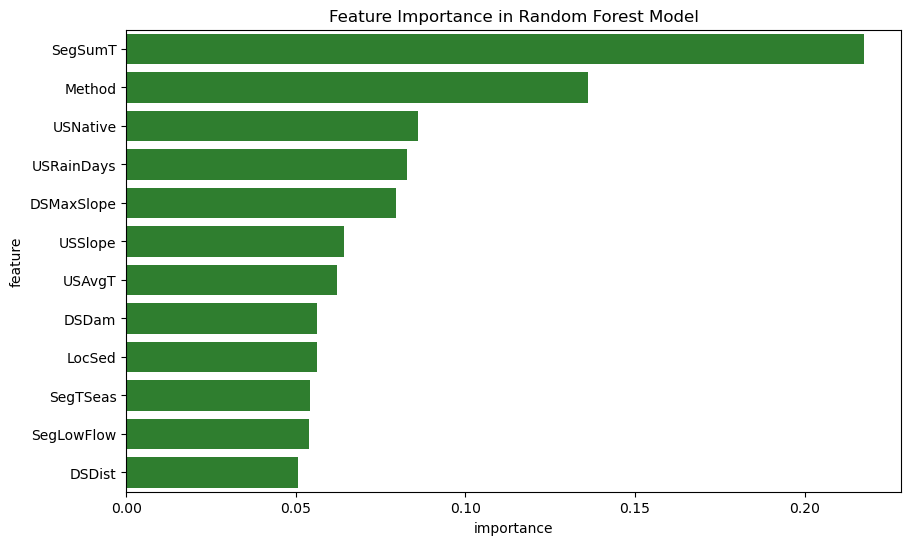

In [48]:
importances = XGB_classifier.feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', color="forestgreen")
plt.title('Feature Importance in Random Forest Model')
plt.show()

### Step 8: The comparison
How does your model's performance compare to the of Elith et al. (See Tables 2 and 3)?  Is there another way to compare the models in addition to predictive performance?  Whose model wins in that regard?

SegSumT, Method, and USNative, are top features in both our recreation and the original paper.

Recreation - Train AUC: 0.801, Test AUC: 0.979 
Elith et al. - Train AUC: 0.858, Test AUC: 0.958. 

We actually performed better on the test data, it is possible we did not overfit our data as our training data is lower. If our model took very long to load, for a 2% increase, the Elith model would be a "better" model, espeically in terms of practicality. This could happen if our dataset was much bigger and our pipeline much more computationally expensive.
